In [3]:
#Section 1 - ELA Image Conversion Function

import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from io import BytesIO
import os

def convert_to_ela_image(path, quality=90):
    """
    Converts an image to its Error Level Analysis (ELA) representation.
    """
    try:
        image = Image.open(path).convert('RGB')
        
        # Save to memory buffer instead of disk to speed up training
        buffer = BytesIO()
        image.save(buffer, 'JPEG', quality=quality)
        buffer.seek(0)
        resaved_image = Image.open(buffer)
        
        # Calculate pixel difference
        ela_image = ImageChops.difference(image, resaved_image)
        
        # Maximize the difference (amplify artifacts)
        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff
        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        
        return ela_image
    except Exception as e:
        print(f"Error converting {path}: {e}")
        return None

In [4]:
# SECTION 2 - New Version - Data Preparation with Memory Optimization

import random
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Configuration
IMG_SIZE = (128, 128)
BATCH_SIZE = 32  # <--- Added this back!
AUTHENTIC_PATH = '../CASIA2/Au' 
TAMPERED_PATH = '../CASIA2/Tp'

X = []
Y = []

def prepare_data(path, class_label):
    print(f"Processing {path}...")
    
    # Get all valid files
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]
    
    # Shuffle BEFORE slicing to get a random sample of the dataset
    random.shuffle(files)
    
    # Limit to 2000 images per class to prevent memory crashes
    for filename in tqdm(files[:2000]): 
        img_path = os.path.join(path, filename)

        # FIX: Randomize quality 90-95 instead of a fixed loop
        # This prevents the model from seeing the same image twice
        random_quality = random.randint(90, 95) 
        
        ela_img = convert_to_ela_image(img_path, quality=random_quality)
        
        if ela_img is not None:
            ela_img = ela_img.resize(IMG_SIZE)
            ela_array = np.array(ela_img).flatten() / 255.0 
            X.append(ela_array)
            Y.append(class_label)

prepare_data(AUTHENTIC_PATH, 0) # Authentic
prepare_data(TAMPERED_PATH, 1)  # Tampered

# Reshape
X = np.array(X)
X = X.reshape(-1, 128, 128, 3) 
Y = to_categorical(Y, 2)

# Split with Stratify
# Stratify ensures the validation set has the same % of Tampered images as the training set
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Training shapes: {X_train.shape}, {Y_train.shape}")

Processing ../CASIA2/Au...


100%|██████████| 2000/2000 [00:47<00:00, 42.16it/s]


Processing ../CASIA2/Tp...


100%|██████████| 2000/2000 [00:58<00:00, 33.96it/s]


Training shapes: (3200, 128, 128, 3), (3200, 2)


In [5]:
# #Section 2 - Data Preparation

# from tqdm import tqdm # Progress bar
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import train_test_split

# # Configuration
# IMG_SIZE = (128, 128)
# BATCH_SIZE = 32
# # Adjust these paths to match your actual CASIA 2.0 location
# AUTHENTIC_PATH = '../CASIA2/Au' 
# TAMPERED_PATH = '../CASIA2/Tp'

# X = []
# Y = []

# def prepare_data(path, class_label):
#     print(f"Processing {path}...")
#     for filename in tqdm(os.listdir(path)[:2000]): # Limit to 2000 for memory safety; remove slice for full dataset
#         if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
#             img_path = os.path.join(path, filename)

#             #ela_img = convert_to_ela_image(img_path)

#             # Generate ELA image at multiple quality levels            
#             for q in [70, 75, 80, 85, 90, 95]:
#                 ela_img = convert_to_ela_image(img_path, quality=q)
            
#             if ela_img is not None:
#                 # Resize and normalize
#                 ela_img = ela_img.resize(IMG_SIZE)
#                 ela_array = np.array(ela_img).flatten() / 255.0 # Normalize pixel values
#                 X.append(ela_array)
#                 Y.append(class_label)

# # 0 for Authentic, 1 for Tempered
# prepare_data(AUTHENTIC_PATH, 0)
# prepare_data(TAMPERED_PATH, 1)

# # Reshape for CNN (Height, Width, Channels)
# X = np.array(X)
# X = X.reshape(-1, 128, 128, 3) 
# Y = to_categorical(Y, 2) # One-hot encoding

# # Split Data (80% Train, 20% Test)
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# print(f"Training shapes: {X_train.shape}, {Y_train.shape}")

In [6]:
#Section 3 - Model Definition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Block 3 (Deeper layer to prevent underfitting)
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Dense Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) # High dropout to prevent overfitting
    model.add(Dense(2, activation='softmax')) # Output layer (Authentic vs Tempered)

    # Compile
    optimizer = Adam(learning_rate=0.0001) # Lower learning rate for stability
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

d:\Programming\DataScience-Practice\Color_edging\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,442 (24.86 MB)

 Trainable params: 6,516,994 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
#SECTION 4 - New Version - Training with Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Create Data Generator
# We rotate and flip images slightly to make the model struggle (learn) more
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10, # Rotate slightly (0-10 degrees)
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

# 2. Callbacks (Same as before)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8,            # Increased patience because augmentation makes training noisier
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4, 
    verbose=1
)

# 3. Fit with Generator
# Note: We use datagen.flow() for X_train, but raw X_val for validation
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    epochs=40,             # Increased epochs because learning is harder now
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save("../models/chaavi_model.h5")
print("Model saved successfully.")

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7925 - loss: 0.7179 - val_accuracy: 0.5000 - val_loss: 4.3820 - learning_rate: 1.0000e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8388 - loss: 0.4161 - val_accuracy: 0.5000 - val_loss: 4.7575 - learning_rate: 1.0000e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8572 - loss: 0.3863 - val_accuracy: 0.5000 - val_loss: 4.5806 - learning_rate: 1.0000e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8653 - loss: 0.3651 - val_accuracy: 0.5000 - val_loss: 2.4361 - learning_rate: 1.0000e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 990ms/step - accuracy: 0.8650 - loss: 0.3613 - val_accuracy: 0.6175 - val_loss: 0.8565 - learning_rate: 1.0000e-04
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8675 - loss: 0.3493 - val_accuracy: 0.8687 - val_loss: 0.3566 - learning_rate: 1.0000e-04
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - a

Model saved successfully.


In [8]:
# #Section 4 - Training with Callbacks
# # Callbacks
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=5,           # Stop if no improvement for 5 epochs
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss', 
#     factor=0.5,           # Reduce learning rate by half if stuck
#     patience=3, 
#     verbose=1
# )

# # Training
# history = model.fit(
#     X_train, Y_train,
#     batch_size=BATCH_SIZE,
#     epochs=30,            # Max epochs (EarlyStopping will likely stop it sooner)
#     validation_data=(X_val, Y_val),
#     callbacks=[early_stopping, reduce_lr],
#     verbose=1
# )

# # Save the final model
# model.save("../models/chaavi_model.h5")
# print("Model saved successfully.")

In [9]:
#Section 5 - Evaluation and Reporting
import json
import os

def save_json(data, folder, filename):
    os.makedirs(folder, exist_ok=True)   # folder auto create
    path = os.path.join(folder, filename)

    with open(path, "w") as f:
        json.dump(data, f, indent=4)

    return path

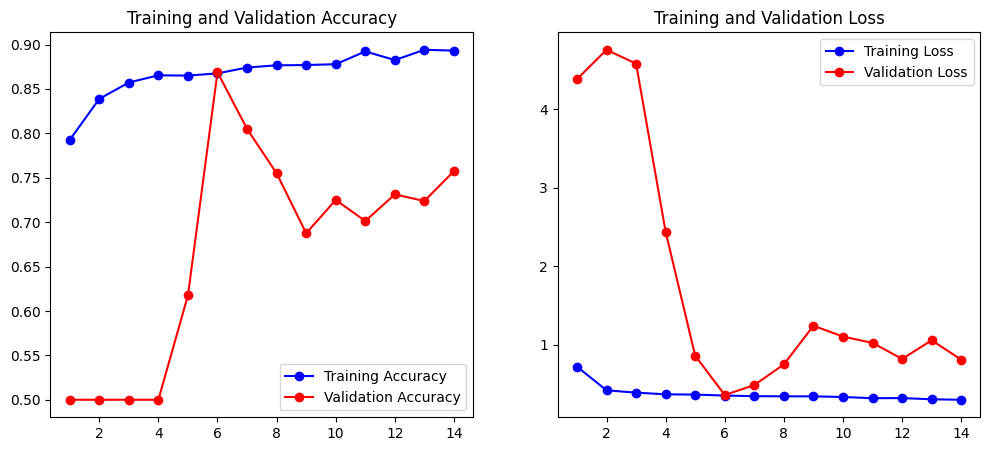

In [10]:
#Section 5.1 - Visualization
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    info = {
        "accuracy": acc,
        "val_accuracy": val_acc,
        "loss": loss,
        "val_loss": val_loss
    }

    save_path = save_json(info, "../models/reports", "model_result.json")
    
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function with the history object from model.fit()
plot_training_history(history)

Generating predictions...
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step

--- Classification Report ---
              precision    recall  f1-score   support

   Authentic       0.99      0.75      0.85       400
    Tempered       0.80      0.99      0.88       400

    accuracy                           0.87       800
   macro avg       0.89      0.87      0.87       800
weighted avg       0.89      0.87      0.87       800



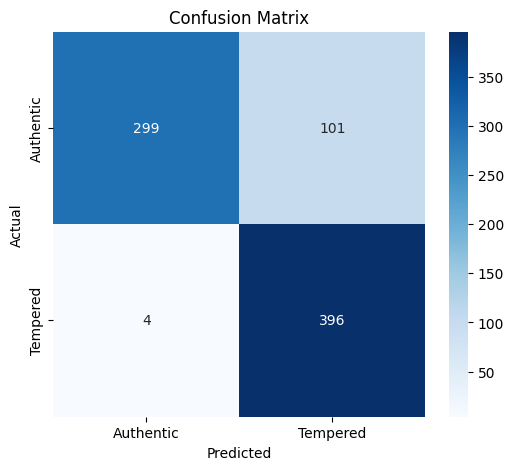

In [11]:
#Section 5.2 - Detailed Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Generate Predictions
print("Generating predictions...")
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1) # Convert probabilities to 0 or 1
Y_true = np.argmax(Y_val, axis=1)          # Convert one-hot to 0 or 1

# 2. Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(Y_true, Y_pred_classes, target_names=['Authentic', 'Tempered']))

# 3. Plot Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Authentic', 'Tempered'], 
            yticklabels=['Authentic', 'Tempered'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
#Section 6 - Single Image Testing
def test_single_image(model, image_path):
    # 1. Convert to ELA
    ela_img = convert_to_ela_image(image_path, quality=90)
    
    if ela_img is not None:
        # 2. Resize and Normalize (Must match training config)
        ela_img = ela_img.resize((128, 128))
        img_array = np.array(ela_img).flatten() / 255.0
        img_array = img_array.reshape(-1, 128, 128, 3)
        
        # 3. Predict
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        label = "Tempered" if class_idx == 1 else "Authentic"
        
        # Display Result
        print(f"Result: {label}")
        print(f"Confidence: {confidence:.2f}%")
        
        # Show the ELA image used for prediction
        plt.imshow(ela_img)
        plt.title(f"ELA Representation - Predicted: {label}")
        plt.axis('off')
        plt.show()
    else:
        print("Could not process image.")

# Example Usage:
# test_single_image(model, "path/to/test_image.jpg")

Loading model from ../models/chaavi_model.h5...


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Result: Tempered
Confidence: 84.71%


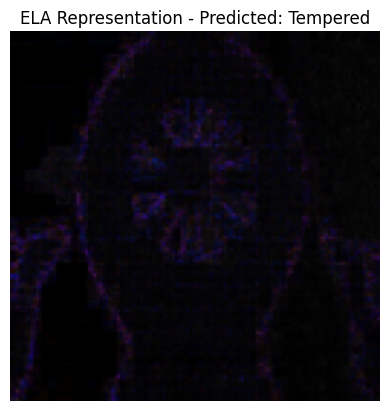

In [13]:
#Section 6.1 - Load Model and Test Single Image
from tensorflow.keras.models import load_model
MODEL_PATH = '../models/chaavi_model.h5' 

if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}...")
    model = load_model(MODEL_PATH)
    print("Model loaded successfully.")
test_single_image(model=model, image_path="../CASIA2/Tp/Tp_D_CNN_M_N_art00052_arc00030_11853.jpg")

Loading model from ../models/chaavi_model.h5...


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Result: Authentic
Confidence: 77.61%


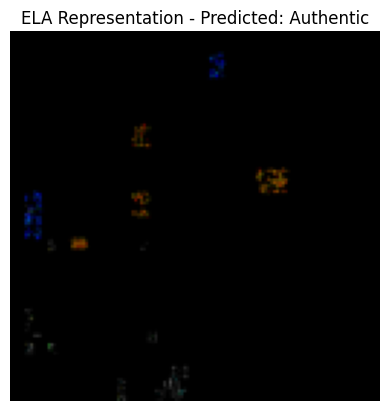

In [14]:
#Section 6.2 - Load Model and Test Single Image
from tensorflow.keras.models import load_model
MODEL_PATH = '../models/chaavi_model.h5' 

if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}...")
    model = load_model(MODEL_PATH)
    print("Model loaded successfully.")
test_single_image(model=model, image_path="../CASIA2/Au/Au_ani_00012.jpg")

Loading model from ../models/chaavi_model.h5...


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step

--- Analysis Result ---
Image: Au_ani_00012.jpg
Prediction: Authentic
Confidence: 77.61%


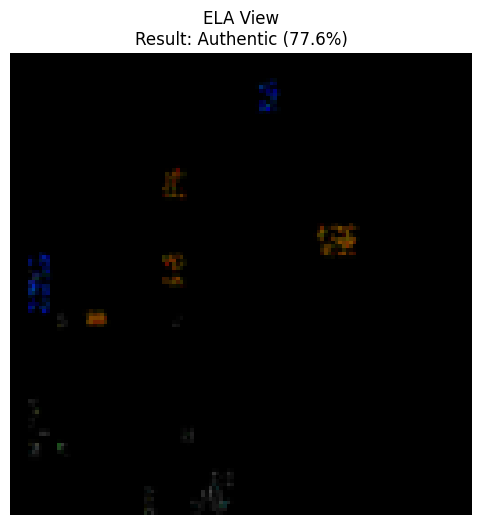

In [15]:
#Section 6.3 - Complete Single Image Testing Script
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image, ImageChops, ImageEnhance
from io import BytesIO
import os

# --- Step 1: Define the ELA Conversion Function ---
# This is required because your model expects ELA images, not raw photos.
def convert_to_ela_image(path, quality=90):
    try:
        image = Image.open(path).convert('RGB')
        
        # Save to memory buffer
        buffer = BytesIO()
        image.save(buffer, 'JPEG', quality=quality)
        buffer.seek(0)
        resaved_image = Image.open(buffer)
        
        # Calculate pixel difference
        ela_image = ImageChops.difference(image, resaved_image)
        
        # Maximize the difference
        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff
        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        
        return ela_image
    except Exception as e:
        print(f"Error converting {path}: {e}")
        return None

# --- Step 2: Define Your Test Function ---
def test_single_image(model, image_path):
    # 1. Convert to ELA
    ela_img = convert_to_ela_image(image_path, quality=90)
    
    if ela_img is not None:
        # 2. Resize and Normalize (Must match training config)
        ela_img = ela_img.resize((128, 128))
        img_array = np.array(ela_img).flatten() / 255.0
        img_array = img_array.reshape(-1, 128, 128, 3)
        
        # 3. Predict
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        # Assuming 0=Authentic, 1=Tempered (Check your training labels!)
        label = "Tempered" if class_idx == 1 else "Authentic"
        
        # Display Result
        print(f"\n--- Analysis Result ---")
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Prediction: {label}")
        print(f"Confidence: {confidence:.2f}%")
        
        # Show the ELA image used for prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(ela_img)
        plt.title(f"ELA View\nResult: {label} ({confidence:.1f}%)")
        plt.axis('off')
        plt.show()
    else:
        print("Could not process image.")

# --- Step 3: Load Model & Run ---

# Update this path to point to your actual .h5 file
MODEL_PATH = '../models/chaavi_model.h5' 

# Update this path to the image you want to test
TEST_IMAGE_PATH = '../CASIA2/Au/Au_ani_00012.jpg' 

if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}...")
    try:
        model = load_model(MODEL_PATH)
        print("Model loaded successfully.")
        
        # Run the test
        test_single_image(model, TEST_IMAGE_PATH)
        
    except Exception as e:
        print(f"Error loading model: {e}")
else:
    print(f"Model file not found at {MODEL_PATH}. Please check the path.")